In [1]:
from collections import namedtuple
import numpy as np
import re
from pipe import select, where, sort
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score, make_scorer
from sklearn.preprocessing import LabelEncoder

import presentation as p

with open('data/network-traffic/kddcup.names.dat') as file:
    col_re = r'(\w+)\:.*'
    cols = [re.search(col_re, line)[1] for line in file.readlines()[1:]] + ['target']

training_df = pd.read_csv('data/network-traffic/kddcup.data.csv', names=cols, index_col=False, header=None)
testing_df = pd.read_csv('data/network-traffic/corrected.csv', names=cols, index_col=False, header=None)
complete_df = pd.concat([training_df, testing_df], axis=0)

# Grouping of Attack Types
attack_group_mapping_ = {
    'neptune': 'dos',
    'satan': 'probe',
    'smurf': 'dos',
    'ipsweep': 'probe',
    'portsweep': 'probe',
    'nmap': 'probe',
    'guess_passwd': 'r2l',
    'back': 'dos',
    'mscan': 'probe',
    'warezmaster': 'r2l',
    'teardrop': 'dos',
    'warezclient': 'r2l',
    'apache2': 'dos',
    'processtable': 'dos',
    'saint': 'probe',
    'snmpguess': 'probe',
    'mailbomb': 'dos',
    'pod': 'dos',
    'snmpgetattack': 'dos',
    'httptunnel': 'r2l',
    'buffer_overflow': 'u2r',
    'land': 'dos',
    'multihop': 'r2l',
    'rootkit': 'u2r',
    'named': 'r2l',
    'ps': 'u2r',
    'sendmail': 'r2l',
    'imap': 'r2l',
    'xterm': 'r2l',
    'loadmodule': 'u2r',
    'ftp_write': 'r2l',
    'xlock': 'r2l',
    'phf': 'r2l',
    'perl': 'u2r',
    'xsnoop': 'r2l',
    'udpstorm': 'dos',
    'spy': 'r2l',
    'worm': 'r2l',
    'sqlattack': 'u2r'
}
def is_attack(target):
    match target:
        case 'normal':
            return False
        case _:
            return True
def group_attack_type(a_type): return attack_group_mapping_[a_type] if is_attack(a_type) else a_type

complete_df['target_group'] = complete_df.target.map(group_attack_type)
training_df['target_group'] = training_df.target.map(group_attack_type)
testing_df['target_group'] = testing_df.target.map(group_attack_type)
complete_df['is_attack'] = complete_df.target.map(is_attack)
training_df['is_attack'] = training_df.target.map(is_attack)
testing_df['is_attack'] = testing_df.target.map(is_attack)

# Numeric columns
scalable_columns = [col for col in complete_df.columns if complete_df[col].dtype == 'float64'] +\
                   [col for col in complete_df.columns if complete_df[col].dtype == 'int64' and complete_df[col].nunique() > 2]
scaler = StandardScaler()
complete_df_scaled = complete_df.copy()
complete_df_scaled[scalable_columns] = scaler.fit_transform(complete_df_scaled[scalable_columns])
training_df_scaled = training_df.copy()
training_df_scaled[scalable_columns] = scaler.fit_transform(training_df_scaled[scalable_columns])
testing_df_scaled = testing_df.copy()
testing_df_scaled[scalable_columns] = scaler.fit_transform(testing_df_scaled[scalable_columns])

# Columns with 'object' type
object_column_names = [complete_df[col].name for col in complete_df.columns if complete_df[col].dtype == 'object']

label_encoder = LabelEncoder()
complete_df_enc_le = complete_df.copy()
complete_df_scaled_enc_le = complete_df_scaled.copy()
training_df_enc_le = training_df.copy()
training_df_scaled_enc_le = training_df_scaled.copy()
testing_df_enc_le = testing_df.copy()
testing_df_scaled_enc_le = testing_df_scaled.copy()
for column in object_column_names:
    complete_df_enc_le[column] = label_encoder.fit_transform(complete_df[column])
    complete_df_scaled_enc_le[column] = label_encoder.transform(complete_df_scaled[column])
    training_df_enc_le[column] = label_encoder.transform(training_df[column])
    training_df_scaled_enc_le[column] = label_encoder.transform(training_df_scaled[column])
    testing_df_enc_le[column] = label_encoder.transform(testing_df[column])
    testing_df_scaled_enc_le[column] = label_encoder.transform(testing_df_scaled[column])

training_df_clean = training_df.drop_duplicates()
training_df_scaled_clean = training_df_scaled.drop_duplicates()
training_df_enc_le_clean = training_df_enc_le.drop_duplicates()
training_df_scaled_enc_le_clean = training_df_scaled_enc_le.drop_duplicates()
testing_df_clean = testing_df.drop_duplicates()
testing_df_scaled_clean = testing_df_scaled.drop_duplicates()
testing_df_enc_le_clean = testing_df_enc_le.drop_duplicates()
testing_df_scaled_enc_le_clean = testing_df_scaled_enc_le.drop_duplicates()
complete_df_clean = complete_df.drop_duplicates()
complete_df_scaled_clean = complete_df_scaled.drop_duplicates()
complete_df_enc_le_clean = complete_df_enc_le.drop_duplicates()
complete_df_scaled_enc_le_clean = complete_df_scaled_enc_le.drop_duplicates()

X_train_is_attack = training_df_scaled_enc_le_clean.drop(['target', 'target_group', 'is_attack'], axis=1)
#X_train_attack_group = training_df_enc_le_clean[training_df_scaled_enc_le_clean.is_attack].drop(['target', 'target_group', 'is_attack'], axis=1)
X_train_attack_group = training_df_scaled_enc_le_clean[training_df_scaled_enc_le_clean.is_attack].drop(['target', 'target_group', 'is_attack'], axis=1)
y_train_is_attack = training_df_scaled_enc_le_clean.is_attack
#y_train_attack_group = training_df_enc_le_clean[training_df_scaled_enc_le_clean.is_attack].target_group
y_train_attack_group = training_df_scaled_enc_le_clean[training_df_scaled_enc_le_clean.is_attack].target_group
X_test_is_attack = testing_df_scaled_enc_le_clean.drop(['target', 'target_group', 'is_attack'], axis=1)
#X_test_attack_group = testing_df_enc_le_clean[testing_df_enc_le_clean.is_attack].drop(['target', 'target_group', 'is_attack'], axis=1)
X_test_attack_group = testing_df_scaled_enc_le_clean[testing_df_enc_le_clean.is_attack].drop(['target', 'target_group', 'is_attack'], axis=1)
y_true_is_attack = testing_df_scaled_enc_le_clean.is_attack
#y_true_attack_group = testing_df_enc_le_clean[testing_df_enc_le_clean.is_attack].target_group
y_true_attack_group = testing_df_scaled_enc_le_clean[testing_df_enc_le_clean.is_attack].target_group

def simple_confusion_matrix(y_true, y_pred, target):
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.blues_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

eval_result = namedtuple('HyperparameterTuningResult', ['model', 'accuracy', 'fbeta'])

def evaluate_model(model, X_test, y_true, beta, average):
    best_params = model.best_params_
    param_string = ''.join((f'\t{key}:\t{value}\n' for key, value in best_params.items()))
    best_score = model.best_score_
    pred = model.predict(X_test)
    acc = accuracy_score(y_true, pred)
    fbeta = fbeta_score(y_true, pred, beta=beta, average=average)
    print('-- Training Results --')
    print(f'Best Parameters:\n{param_string}', end='')
    print(f'Best Score:\n\t{best_score:.6f}')
    print('\n-- Testing Results --')
    print(f'Accuracy    on Verification Data:\t{acc:.6f}')
    print(f'Fbeta scroe on Verification Data:\t{fbeta:.6f}\n')
    print(classification_report(y_true, pred))
    return eval_result(model, acc, fbeta)

In [2]:
# Metrics
betas = [1, 5, 10, 50, 100, 500, 1000]
fbeta_average = 'weighted'
accuracy_scorer = make_scorer(accuracy_score)
def fbeta_scorer(beta): return make_scorer(fbeta_score, beta=beta, average=fbeta_average)

In [3]:
rf_param_grid = {
    'n_estimators': [20, 50, 100, 150],             # number of trees
    'max_depth': [5, 10, 20, 35],                   # maximum tree size (number of decisions)
    'criterion': ['gini', 'entropy', 'log_loss'],   # split criterion
    'n_jobs': [-1],                                 # number of parallel jobs; use all available cores
    'random_state': [404],                          # for reproducibility
}

In [4]:
def hyperparameter_tuning(parameter_grid, base_estimator, X_train, y_train, scoring, refit=True, verbose=3):
    return GridSearchCV(estimator=base_estimator, param_grid=parameter_grid, refit=refit, verbose=verbose, scoring=scoring).fit(X_train, y_train)

In [ ]:
rf_is_attack_grid_search = [
    hyperparameter_tuning(
        parameter_grid=rf_param_grid,
        base_estimator=RandomForestClassifier(),
        X_train=X_train_is_attack,
        y_train=y_train_is_attack,
        scoring=fbeta_scorer(beta)
    )
    for beta in betas
]

In [12]:
def evaluate_model(model, X_test, y_true, beta, average):
    best_params = model.best_params_
    param_string = ''.join((f'\t{key}:\t{value}\n' for key, value in best_params.items()))
    best_score = model.best_score_
    pred = model.predict(X_test)
    acc = accuracy_score(y_true, pred)
    fbeta = fbeta_score(y_true, pred, beta=beta, average=average)
    print('-- Training Results --')
    print(f'Best Parameters:\n{param_string}', end='')
    print(f'Best Score:\n\t{best_score:.6f}')
    print('\n-- Testing Results --')
    print(f'Accuracy    on Verification Data:\t{acc:.6f}')
    print(f'Fbeta scroe on Verification Data:\t{fbeta:.6f}\n')
    print(classification_report(y_true, pred))
    return eval_result(model, acc, fbeta)

-- Training Results --
Best Parameters:
	criterion:	entropy
	max_depth:	20
	n_estimators:	50
	n_jobs:	-1
	random_state:	404
Best Score:
	0.997550

-- Testing Results --
Accuracy    on Verification Data:	0.934921
Fbeta scroe on Verification Data:	0.934323

              precision    recall  f1-score   support

       False       0.93      0.97      0.95     47913
        True       0.95      0.87      0.91     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.92      0.93     77291
weighted avg       0.94      0.93      0.93     77291



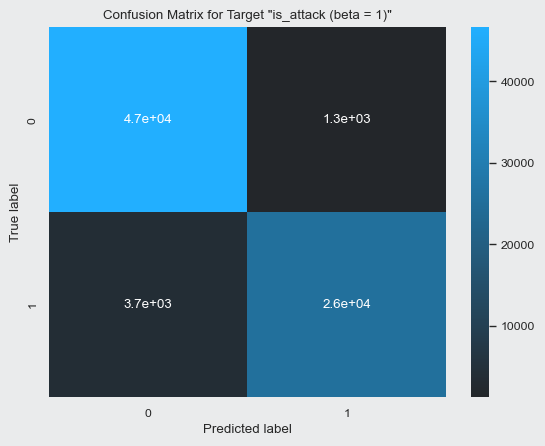

-- Training Results --
Best Parameters:
	criterion:	entropy
	max_depth:	20
	n_estimators:	50
	n_jobs:	-1
	random_state:	404
Best Score:
	0.997558

-- Testing Results --
Accuracy    on Verification Data:	0.934921
Fbeta scroe on Verification Data:	0.934806

              precision    recall  f1-score   support

       False       0.93      0.97      0.95     47913
        True       0.95      0.87      0.91     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.92      0.93     77291
weighted avg       0.94      0.93      0.93     77291



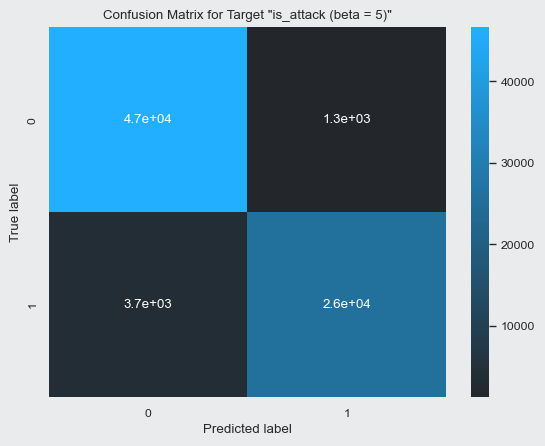

-- Training Results --
Best Parameters:
	criterion:	entropy
	max_depth:	20
	n_estimators:	50
	n_jobs:	-1
	random_state:	404
Best Score:
	0.997559

-- Testing Results --
Accuracy    on Verification Data:	0.934921
Fbeta scroe on Verification Data:	0.934891

              precision    recall  f1-score   support

       False       0.93      0.97      0.95     47913
        True       0.95      0.87      0.91     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.92      0.93     77291
weighted avg       0.94      0.93      0.93     77291



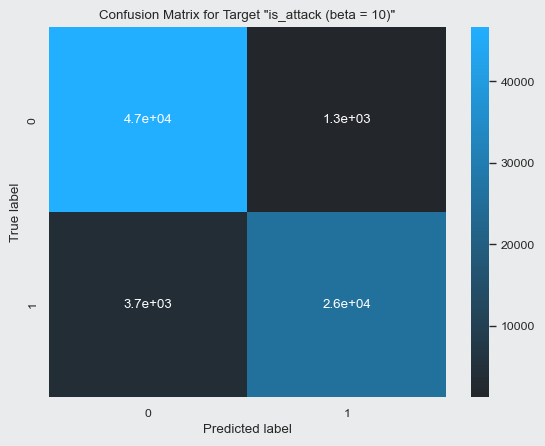

-- Training Results --
Best Parameters:
	criterion:	entropy
	max_depth:	20
	n_estimators:	50
	n_jobs:	-1
	random_state:	404
Best Score:
	0.997560

-- Testing Results --
Accuracy    on Verification Data:	0.934921
Fbeta scroe on Verification Data:	0.934920

              precision    recall  f1-score   support

       False       0.93      0.97      0.95     47913
        True       0.95      0.87      0.91     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.92      0.93     77291
weighted avg       0.94      0.93      0.93     77291



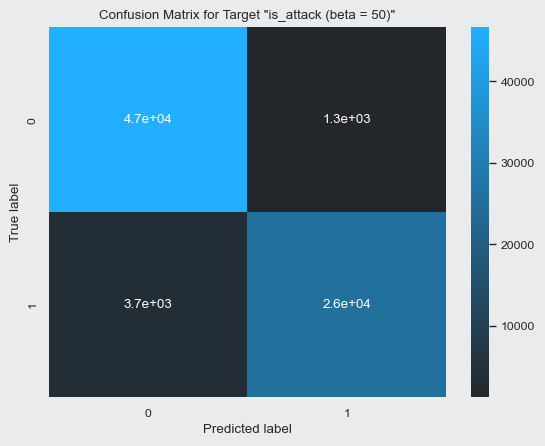

-- Training Results --
Best Parameters:
	criterion:	entropy
	max_depth:	20
	n_estimators:	50
	n_jobs:	-1
	random_state:	404
Best Score:
	0.997560

-- Testing Results --
Accuracy    on Verification Data:	0.934921
Fbeta scroe on Verification Data:	0.934921

              precision    recall  f1-score   support

       False       0.93      0.97      0.95     47913
        True       0.95      0.87      0.91     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.92      0.93     77291
weighted avg       0.94      0.93      0.93     77291



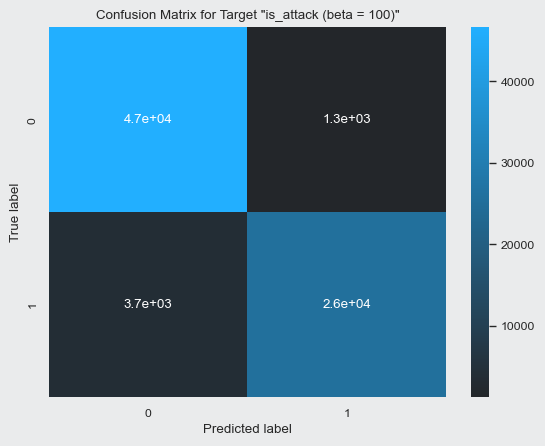

-- Training Results --
Best Parameters:
	criterion:	entropy
	max_depth:	20
	n_estimators:	50
	n_jobs:	-1
	random_state:	404
Best Score:
	0.997560

-- Testing Results --
Accuracy    on Verification Data:	0.934921
Fbeta scroe on Verification Data:	0.934921

              precision    recall  f1-score   support

       False       0.93      0.97      0.95     47913
        True       0.95      0.87      0.91     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.92      0.93     77291
weighted avg       0.94      0.93      0.93     77291



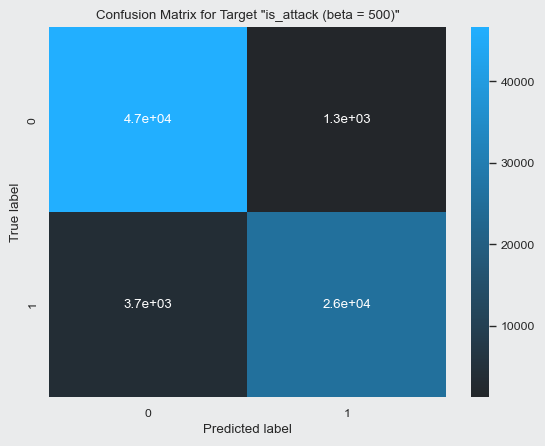

-- Training Results --
Best Parameters:
	criterion:	entropy
	max_depth:	20
	n_estimators:	50
	n_jobs:	-1
	random_state:	404
Best Score:
	0.997560

-- Testing Results --
Accuracy    on Verification Data:	0.934921
Fbeta scroe on Verification Data:	0.934921

              precision    recall  f1-score   support

       False       0.93      0.97      0.95     47913
        True       0.95      0.87      0.91     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.92      0.93     77291
weighted avg       0.94      0.93      0.93     77291



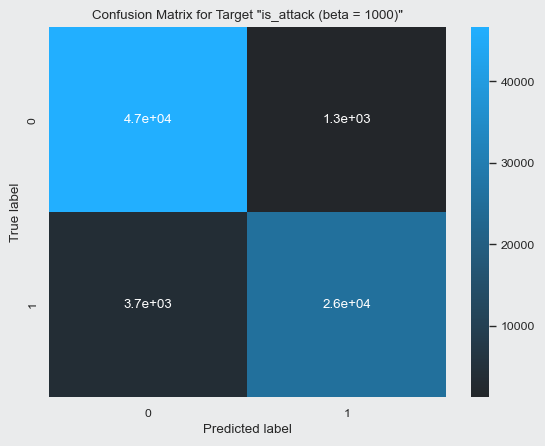

In [14]:
for idx, model in enumerate(rf_is_attack_grid_search):
    evaluate_model(model, X_test_is_attack, y_true_is_attack, betas[idx], fbeta_average)
    y_pred = model.predict(X_test_is_attack)
    simple_confusion_matrix(y_true_is_attack, y_pred, f'is_attack (beta = {betas[idx]})')